# Modelos Aprendizagem Máquina

In [1]:
import sys

!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} nbformat
!conda install --yes --prefix {sys.prefix} plotly==4.6.0
!conda install --yes --prefix {sys.prefix} psutil requests
!conda install --yes --prefix {sys.prefix} scikit-learn
!conda install --yes --prefix {sys.prefix} plotly-orca==1.2.1

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.

done

# All requested packages already installed.



In [2]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
from plotly.graph_objs import *
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime

import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = "svg"

# Ler os dados
data = pd.read_csv('./brazil_covid19.csv')

## Regressão Linear
O primeiro modelo a aplicar aos dados será uma simples regressão linear, de modo a podermos analisar qual vai ser o seu comportamento na previsão do nº de casos.

Primeiro, é necessário preparar os dados para a regressão. Definiu-se que o *holdout* seria realizar o treino com 90% dos dados (90% desde primeiro dia) e o teste com os 10% dias restantes.

In [3]:
data_by_day = data.groupby(['date'])['cases','deaths'].agg('sum')

df1 = data_by_day
df1 = df1.reset_index()

# Filtrar desde primeiro caso
#df1 = df1.loc[df1['date'] >= '2020-02-26']

# Inserir coluna de dias
df1['days'] = range(1, len(df1) + 1)


# Treino
days_train = df1['days'][:int(0.9*len(df1))]
cases_train = df1['cases'][:int(0.9*len(df1))]

# Teste
days_test = df1['days'][int(0.9*len(df1)):]
cases_test =  df1['cases'][int(0.9*len(df1)):]

estimate = len(df1) - len(days_test)

print("Total Dados: %d, Treino: %d dias, Teste: %d dias" % (len(df1),len(days_train),len(days_test)))

Total Dados: 92, Treino: 82 dias, Teste: 10 dias


Tendo o *holdout* definido, passamos à computação do modelo com os dados de treino, e a respetiva previsão com os dados de teste. 

É feito um gráfico de modo a podermos visualizar esta estimativa, e no final são calculadas as métricas do Erro Médio Quadrático e do coeficiente R^2, para avaliar o modelo.

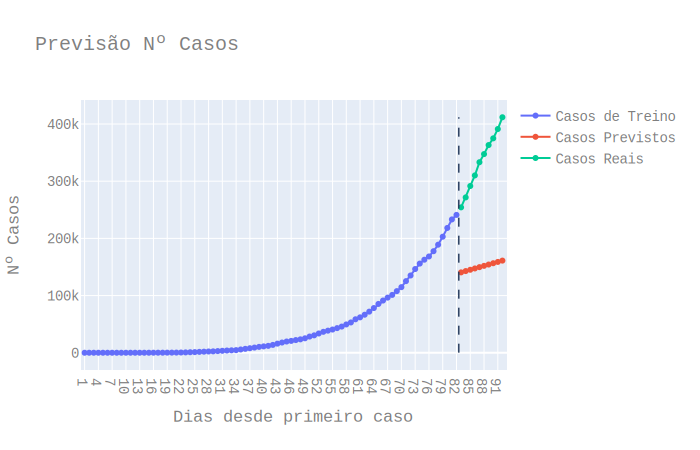

In [4]:

# Regressão Linear
reg = LinearRegression().fit(days_train.values.reshape(-1,1), cases_train)
cases_estimate = reg.predict(days_test.values.reshape(-1,1))

# Plot
layout = Layout(
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ),
    title= "Previsão Nº Casos",
    xaxis_title="Dias desde primeiro caso",
    yaxis_title="Nº Casos",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 3,
        range=[0,len(df1)+1]
    )
)

fig = go.Figure(data=[
    go.Scatter(x=days_train, y=cases_train, name='Casos de Treino',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_estimate, name = 'Casos Previstos',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_test, name = 'Casos Reais',mode="lines+markers")
])

fig.add_shape(
        dict(
            type="line",
            x0=estimate + 0.5,
            y0=120,
            x1=estimate + 0.5,
            y1=max(df1['cases']),
            line=dict(
                width=1.5,
                dash= "dash"
            )
))

fig['layout'].update(layout)
fig.show()

In [5]:
print("Erro Médio Quadrático: ",mean_squared_error(cases_test,cases_estimate))
print("Coeficiente R^2: ", r2_score(cases_test,cases_estimate))

Erro Médio Quadrático:  35748372147.66532
Coeficiente R^2:  -13.499758780708644


Ao analisar o gráfico, repara-se que o modelo subestima muito o nº de casos em relação ao nº real.

Torna-se assim claro que não existe forma de uma regressão linear prever bem o formato do crescimento de casos.

No entando, para melhorar os resultados, decidimos atacar problema usando uma regressão linear múltipla, juntando assim o número de mortes às variáveis preditoras.

In [6]:
df2 = df1[['days','deaths']]
df2_test = df2[int(len(days_train)):] 
df2 = df2[:int(len(days_train))]

reg = LinearRegression().fit(df2, cases_train)
cases_estimate = reg.predict(df2_test)

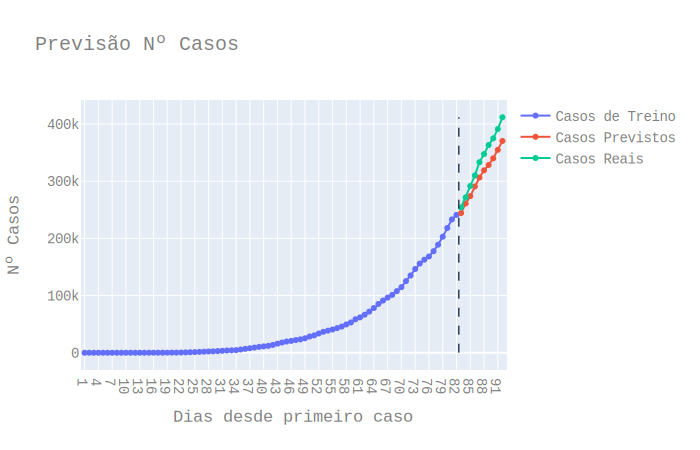

In [7]:
# Plot
layout = Layout(
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ),
    title= "Previsão Nº Casos",
    xaxis_title="Dias desde primeiro caso",
    yaxis_title="Nº Casos",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 3,
        range=[0,len(df1)+1]
    )
)

fig = go.Figure(data=[
    go.Scatter(x=days_train, y=cases_train, name='Casos de Treino',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_estimate, name = 'Casos Previstos',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_test, name = 'Casos Reais',mode="lines+markers")
])

fig.add_shape(
        dict(
            type="line",
            x0=estimate + 0.5,
            y0=120,
            x1=estimate + 0.5,
            y1=max(df1['cases']),
            line=dict(
                width=1.5,
                dash= "dash"
            )
))

fig['layout'].update(layout)
fig.show()

In [8]:
print("Erro Médio Quadrático: ",mean_squared_error(cases_test,cases_estimate))
print("Coeficiente R^2: ", r2_score(cases_test,cases_estimate))

Erro Médio Quadrático:  790823446.3904221
Coeficiente R^2:  0.6792371646064261


Podemos verificar que o modelo de regressão linear múltipla não substima o nº de casos em relação ao nº real, contrariamente ao modelo de regressão linear simples.

## Modelo de regressão Support Vector Regression (SVR)
Iremos agora aplicar um modelo de regressão SVR. Neste modelo podemos verificar como se comporta a regressão dos dados num mapeamento não-linear.

Começamos por determinar os melhores parametros, e de seguida treinamos o modelo.

In [9]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
param_grid = {
    'kernel' : ['linear','poly'],
    'C' : [100,500,1000],
    'coef0' : [5,10,15,20]
}
from sklearn.svm import SVR
svm_model = SVR()
clf = GridSearchCV(svm_model, param_grid)
model_svm = clf.fit(days_train.values.reshape(-1,1), cases_train)
svm_model = model_svm.best_estimator_
cases_estimate = svm_model.predict(days_test.values.reshape(-1,1))

In [10]:
model_svm.best_params_

{'C': 500, 'coef0': 5, 'kernel': 'poly'}

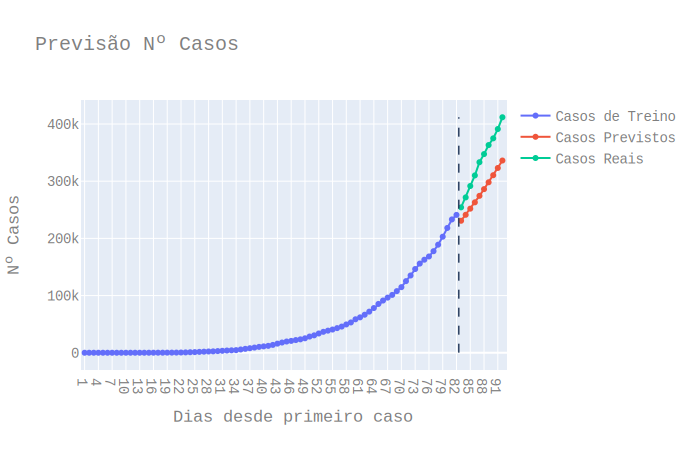

In [11]:
# Plot
layout = Layout(
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="#7f7f7f"
    ),
    title= "Previsão Nº Casos",
    xaxis_title="Dias desde primeiro caso",
    yaxis_title="Nº Casos",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 3,
        range=[0,len(df1)+1]
    )
)

fig = go.Figure(data=[
    go.Scatter(x=days_train, y=cases_train, name='Casos de Treino',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_estimate, name = 'Casos Previstos',mode="lines+markers"),
    go.Scatter(x=days_test, y=cases_test, name = 'Casos Reais',mode="lines+markers")
])

fig.add_shape(
        dict(
            type="line",
            x0=estimate + 0.5,
            y0=120,
            x1=estimate + 0.5,
            y1=max(df1['cases']),
            line=dict(
                width=1.5,
                dash= "dash"
            )
))

fig['layout'].update(layout)
fig.show()

In [12]:
print("Erro Médio Quadrático: ",mean_squared_error(cases_test,cases_estimate))
print("Coeficiente R^2: ", r2_score(cases_test,cases_estimate))

Erro Médio Quadrático:  3122823101.087479
Coeficiente R^2:  -0.26663618397936384


Como podemos verificar este modelo, mesmo não sendo melhor que o modelo de regressão linear múltipla, é bastante razoável para a predição do nº de casos.